# Flight Delay Prediction
This project aims to predict flight arrival delays based on historical flight data using multiple machine learning models.

The goal of this project is to accurately predict flight arrival delays using structured airline and airport data.

Rather than focusing on complex or deep models, the primary objective was to build meaningful features and a robust end-to-end pipeline. This includes detailed data cleaning, data transformation, time features and airport and airline related features.

The modeling approach uses three ml models — Linear Regression, XGBoost, and a simple Neural Network — to compare performance and highlight the impact of feature engineering.

All components (preprocessing, training, prediction, and evaluation) were designed with modularity and reproducibility in mind, and this project is deployable, testable, and extendable.

The idea of the project was to build machine learning models based on the data in the flights_train and then to use it to predict the values in flights_test

We removed outliers from the training data values of arrival delay beyond the 1st and 99th percentiles—to reduce the impact of extreme cases and to compare the performance of the predictive models

The reported results (Neural Network: MSE 111.84, R² 0.9317; XGBoost: MSE 141.43, R² 0.9136; Linear Regression: MSE 1371.25, R² 0.1620) were obtained using the full dataset with outliers included;

The reported results (Neural Network: MSE 85.47, R² 0.8967; XGBoost: MSE 83.96, R² 0.8985; Linear Regression: MSE 664.52, R² 0.1970) were obtained using the full dataset without outliers included;

Removing outliers (arrival delays outside the 1st–99th percentile) led to a significant reduction in MSE for all models, especially Linear Regression, but a slight decrease in R² for the nonlinear models (XGBoost and Neural Network).

Neural Network and XGBoost remain the best performers in both cases, with high R² values (around 0.90), showing strong predictive power.

Linear Regression improved in MSE but only modestly in R², reflecting its limited ability to capture complex patterns.

Takeaway: Removing extreme delays improves average error (MSE), but may slightly reduce R² since some overall variance is removed. Nonlinear models are robust and effective for this problem.


In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 999
pd.options.display.max_columns = 50


# Data Loading


In [2]:
flights_test = pd.read_csv('data/flights_test.csv')
flights_train = pd.read_csv('data/flights_train.csv')
airlines = pd.read_csv('data/airlines.csv')
airports = pd.read_csv('data/airports.csv')

In [4]:
# check the training data
flights_train.head(36)

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0
5,5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,20.0,18.0,38.0,217.0,1589,602,8.0
6,6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,19.0,11.0,30.0,181.0,1299,526,-17.0
7,7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,44.0,13.0,57.0,273.0,2125,803,-10.0
8,8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,19.0,17.0,36.0,195.0,1464,545,-13.0
9,9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,33.0,12.0,45.0,221.0,1747,711,-15.0


Explanation of the columns:

id – Unique identifier for each flight record.

YEAR – The calendar year the flight occurred (e.g., 2015).

MONTH – The month of the flight (1 = January, ..., 12 = December).

DAY – The day of the month when the flight was scheduled.

DAY_OF_WEEK – Numerical representation of the weekday (1 = Monday, ..., 7 = Sunday).

AIRLINE – IATA code of the airline operating the flight.

FLIGHT_NUMBER – Numeric flight identifier assigned by the airline.

TAIL_NUMBER – Aircraft registration number (unique to the airplane).

ORIGIN_AIRPORT – IATA code of the airport where the flight originated.

DESTINATION_AIRPORT – IATA code of the destination airport.

SCHEDULED_DEPARTURE – Scheduled departure time in minutes after midnight.

DEPARTURE_TIME – Actual recorded departure time in minutes after midnight.

TAXI_OUT – Time in minutes spent taxiing from gate to takeoff.

WHEELS_OFF – Time in minutes after midnight when the plane took off.

SCHEDULED_TIME – Planned duration of the flight in minutes.

DISTANCE – Distance of the flight in miles.

SCHEDULED_ARRIVAL – Scheduled arrival time in minutes after midnight.

ARRIVAL_DELAY – Delay in arrival in minutes (negative means early).

### 1. Dataset Overview
We start by examining the structure of the dataset — the number of rows and columns, data types, and presence of missing values — to understand what preprocessing is needed. Then we will build some visualizations to understand more the data and the correlation between the features



In [5]:
print(f'data shape: {flights_train.shape}')
flights_train.info()

data shape: (2818553, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818553 entries, 0 to 2818552
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   YEAR                 int64  
 2   MONTH                int64  
 3   DAY                  int64  
 4   DAY_OF_WEEK          int64  
 5   AIRLINE              object 
 6   FLIGHT_NUMBER        int64  
 7   TAIL_NUMBER          object 
 8   ORIGIN_AIRPORT       object 
 9   DESTINATION_AIRPORT  object 
 10  SCHEDULED_DEPARTURE  int64  
 11  DEPARTURE_TIME       float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  DISTANCE             int64  
 16  SCHEDULED_ARRIVAL    int64  
 17  ARRIVAL_DELAY        float64
dtypes: float64(5), int64(9), object(4)
memory usage: 387.1+ MB


### 2. Missing Values Analysis
Identifying columns with missing values helps determine which features need imputation or removal.


In [6]:
# check if there are any null values in the columns. There is no therefore we do no need to do anything further
flights_train.isnull().sum().sort_values(ascending=False)


id                     0
YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
DISTANCE               0
SCHEDULED_ARRIVAL      0
ARRIVAL_DELAY          0
dtype: int64

### 3. Target Variable Distribution
We explore the distribution of the target ARRIVAL_DELAY to detect skewness, outliers


<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='ARRIVAL_DELAY', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Arrival Delay')

Text(0.5, 0, 'Arrival Delay (minutes)')

Text(0, 0.5, 'Frequency')

(-100.0, 300.0)

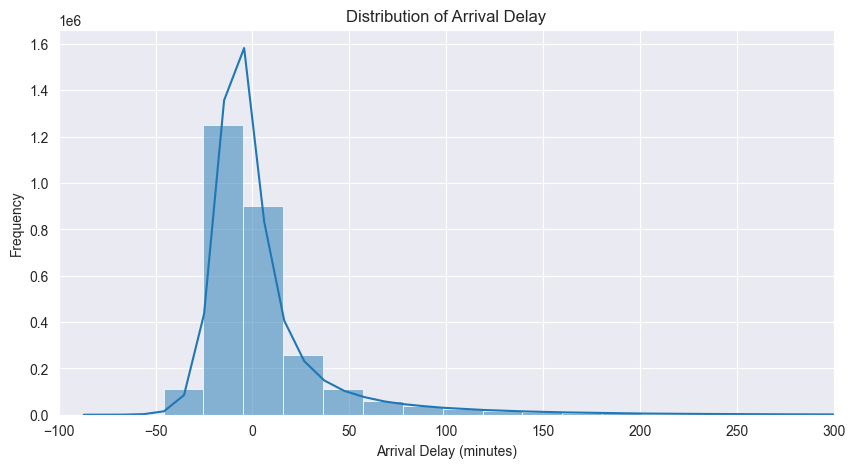

In [7]:

plt.figure(figsize=(10, 5))
sns.histplot(flights_train['ARRIVAL_DELAY'], bins=100, kde=True)
plt.title('Distribution of Arrival Delay')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.xlim(-100, 300)
plt.grid(True)
plt.show()



<Axes: xlabel='ARRIVAL_DELAY'>

Text(0.5, 1.0, 'Boxplot of Arrival Delay')

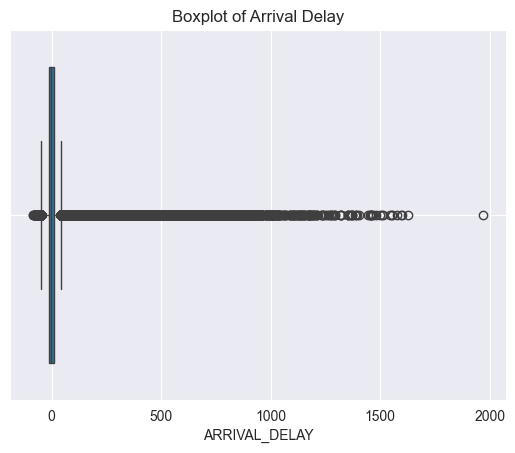

In [8]:
sns.boxplot(x=flights_train['ARRIVAL_DELAY'])
plt.title("Boxplot of Arrival Delay")
plt.grid(True)
plt.show()

In [9]:
threshold_99 = flights_train['ARRIVAL_DELAY'].quantile(0.99)
print(f"99th percentile: {threshold_99:.2f} minutes")

99th percentile: 173.00 minutes


### 4. Unique Values
From this we can see that columns like TAIL_NUMBER or FLIGHT_NUMBER have too many unique values therefore we do not need them for the models


In [10]:
flights_train.nunique().sort_values(ascending=False)


id                     2818553
FLIGHT_NUMBER             6603
TAIL_NUMBER               4688
WHEELS_OFF                1440
DEPARTURE_TIME            1440
SCHEDULED_ARRIVAL         1394
DISTANCE                  1315
SCHEDULED_DEPARTURE       1283
ARRIVAL_DELAY             1098
SCHEDULED_TIME             508
ORIGIN_AIRPORT             322
DESTINATION_AIRPORT        322
TAXI_OUT                   184
DAY                         31
AIRLINE                     14
DAY_OF_WEEK                  7
MONTH                        6
YEAR                         1
dtype: int64

### 5. Correlation Matrix
We build a correlation matrix to see the correlation between the numeric features and the Arrival Delay. We will do the same after we build the other features.

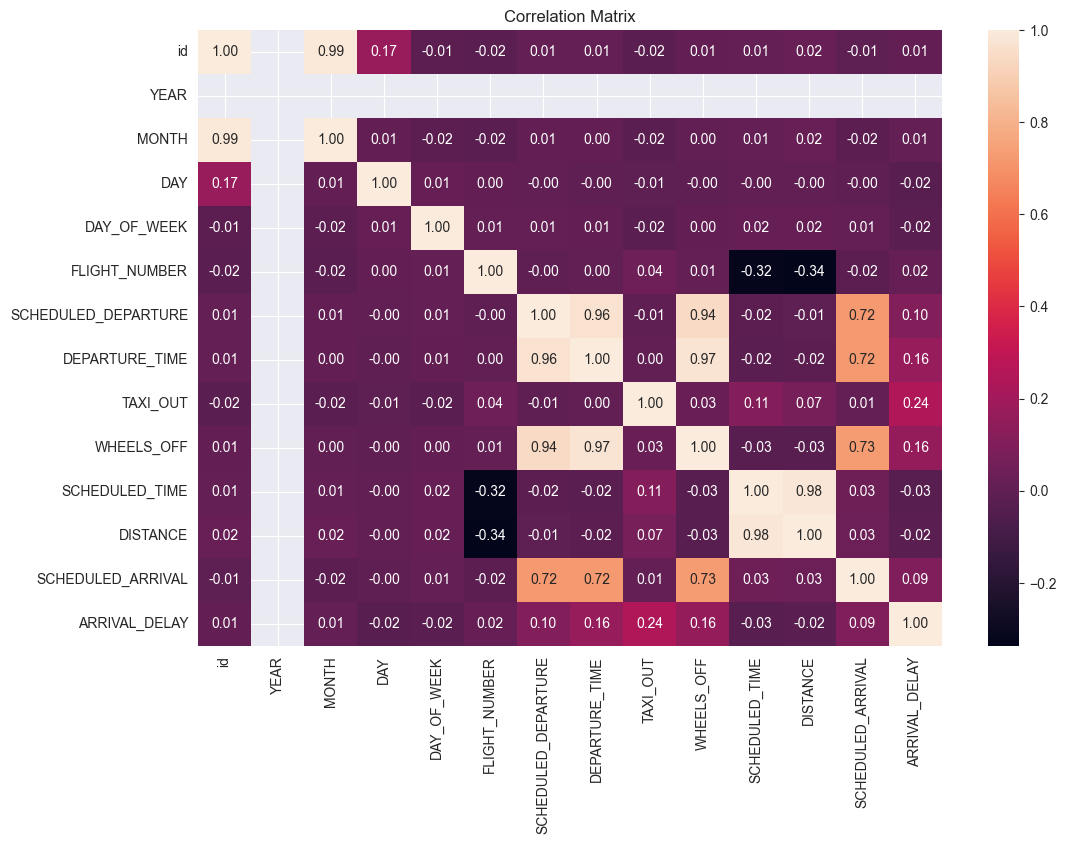

In [11]:
plt.figure(figsize=(12, 8))
corr = flights_train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show();

### 6. Categorical Value Frequency
Categorical features like AIRLINE, ORIGIN_AIRPORT, and DAY_OF_WEEK are evaluated for variability and relevance.

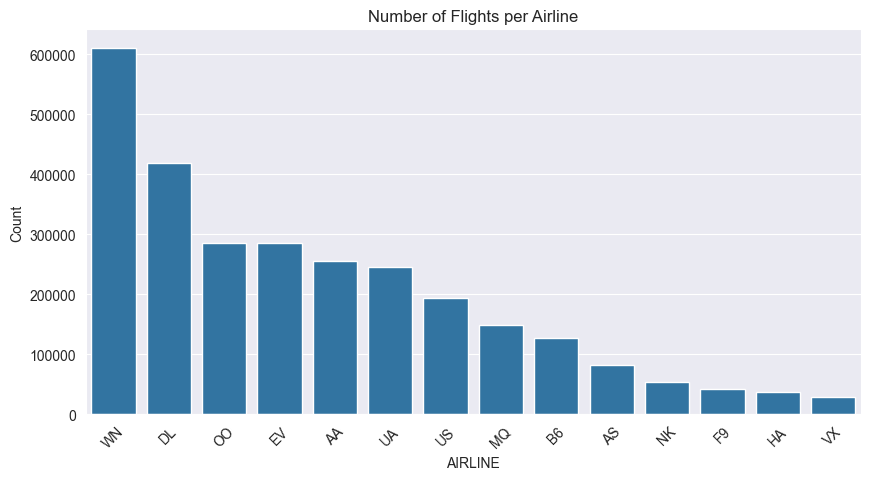

In [12]:

# Airline Distribution

plt.figure(figsize=(10, 5))
sns.countplot(data=flights_train, x='AIRLINE', order=flights_train['AIRLINE'].value_counts().index)
plt.title('Number of Flights per Airline')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show();

### 7. Airline Delay Statistics

To understand how airline behavior affects arrival delays, we compute summary statistics per carrier — including average delay, max, min, and number of flights. This gives insight into which airlines are most likely to be on time or delayed.

In [13]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

airline_stats = flights_train['ARRIVAL_DELAY'].groupby(flights_train['AIRLINE']).apply(get_stats).unstack()
airline_stats = airline_stats.sort_values('count', ascending=False)

airlines = airlines.merge(airline_stats, left_on='IATA_CODE', right_index=True, how='left')

airline_stats

,min,max,count,mean
AIRLINE,,,,
WN,-73.0,659.0,610684.0,5.007338
DL,-79.0,1274.0,419380.0,1.694466
OO,-57.0,970.0,285220.0,6.455536
EV,-63.0,1196.0,285191.0,8.617050
AA,-87.0,1971.0,256098.0,6.551453
UA,-81.0,1294.0,244880.0,7.915853
US,-87.0,750.0,194223.0,3.706209
MQ,-63.0,1152.0,149746.0,11.815074
B6,-76.0,952.0,127305.0,6.968689


### 8. Arrival Delay Distribution by Airline

This stripplot shows the spread of arrival delays for each airline. It helps identify carriers that are consistently late or exhibit high variance in delay times.

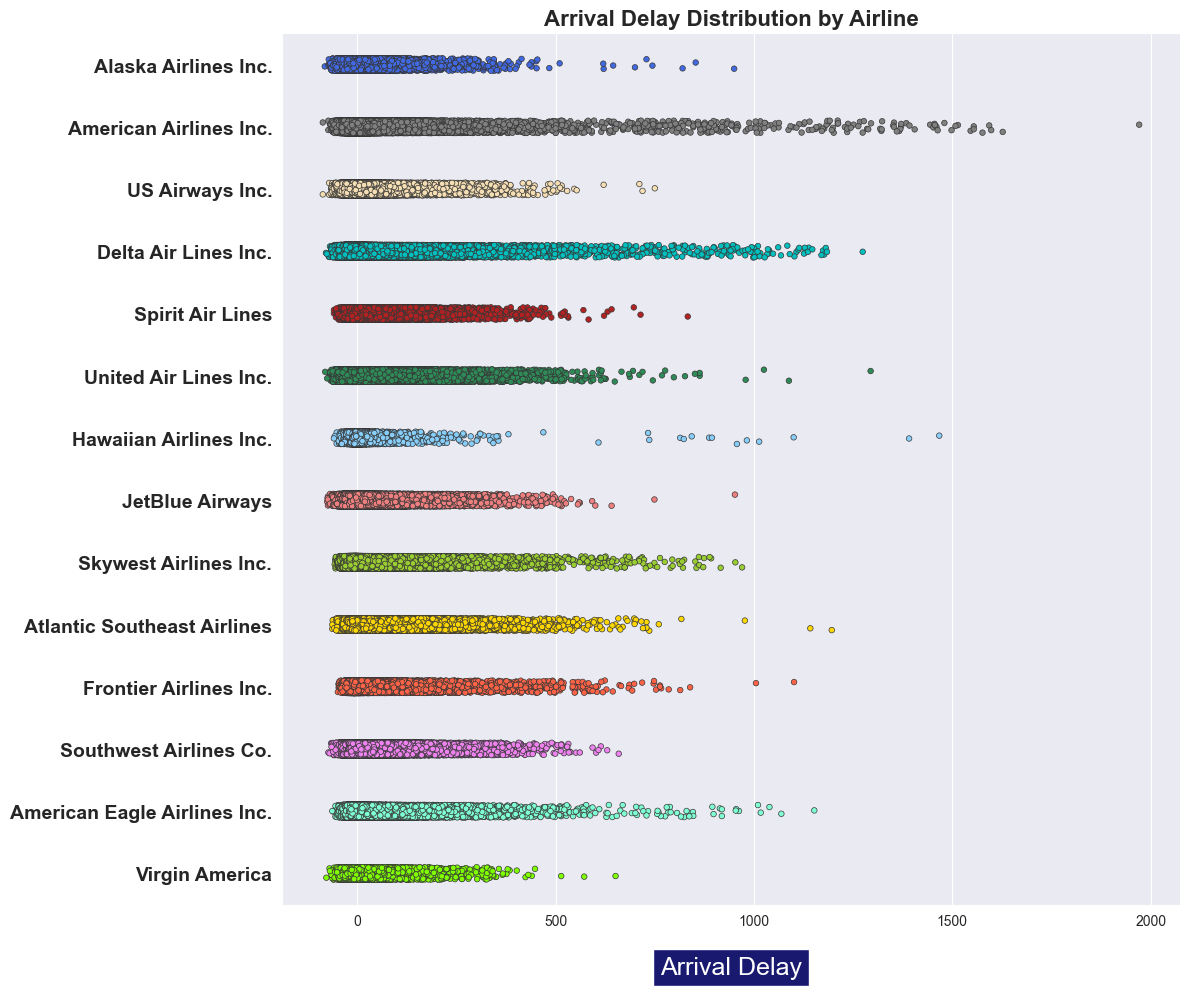

In [14]:
new_data = flights_train.copy()

df2 = new_data.loc[:, ['AIRLINE', 'ARRIVAL_DELAY']]

# Custom color palette (14 distinct colors for 14 airlines)
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

# full airline names
abbr_companies = dict(zip(airlines['IATA_CODE'], airlines['AIRLINE']))

# Create the plot
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
sns.stripplot(y="AIRLINE", x="ARRIVAL_DELAY", hue="AIRLINE", size=4, palette=colors,
              data=df2, linewidth=0.5, jitter=True, ax=ax, legend=False)

# Format x-axis as hh:mm
# xticks = ax.get_xticks()
# ax.set_xticks(xticks)
# ax.set_xticklabels([
#     ('early' if x < 0 else '{:2.0f}h{:02.0f}m'.format(*divmod(x, 60)))
#     for x in xticks
# ], fontsize=14)

# Format y-axis with full airline names
labels = [abbr_companies.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels, fontsize=14, weight='bold')

# styling
ax.yaxis.label.set_visible(False)
plt.xlabel('Arrival Delay', fontsize=18, bbox={'facecolor': 'midnightblue', 'pad': 5}, color='white', labelpad=20)
plt.title('Arrival Delay Distribution by Airline', fontsize=16, weight='bold')
plt.tight_layout()
plt.show();


### 9. Delay Category Distribution per Airline

We classify flights into three categories:
- On time (< 5 min delay)
- Small delay (5–45 min)
- Large delay (> 45 min)

This bar chart shows the frequency of each category per airline.

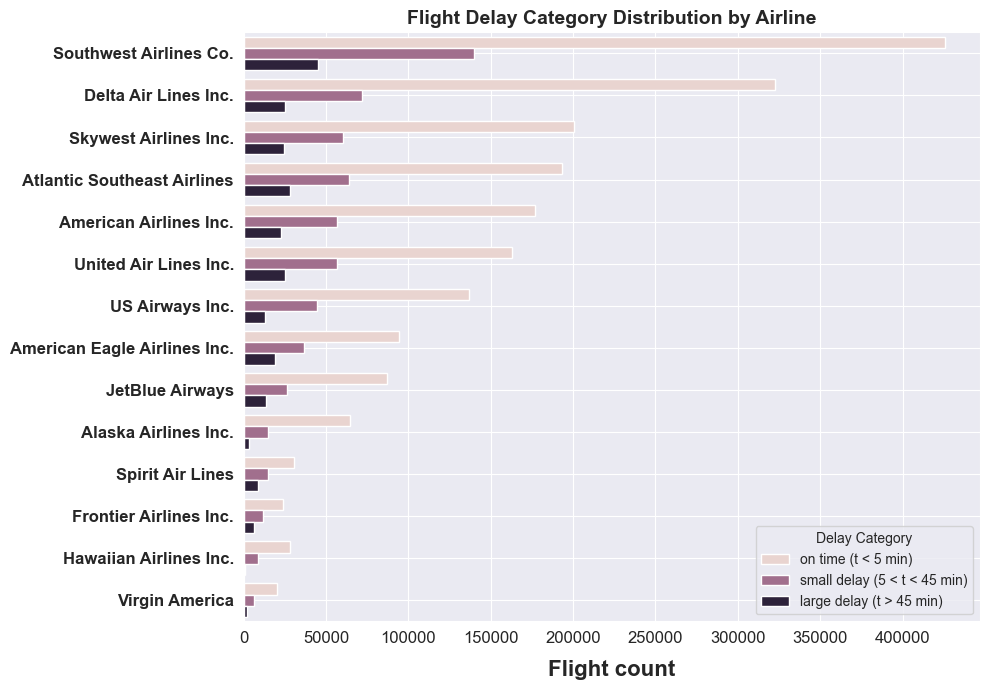

In [15]:
delay_type = lambda x: ((0, 1)[x > 5], 2)[x > 45]
new_data = flights_train.copy()
new_data['DELAY_LEVEL'] = new_data['ARRIVAL_DELAY'].apply(delay_type)

# Airline abbreviation mapping (adjust as needed)
abbr_companies = dict(zip(airlines['IATA_CODE'], airlines['AIRLINE']))

# Create the plot
fig = plt.figure(1, figsize=(10, 7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=new_data, order=new_data['AIRLINE'].value_counts().index)

# Replace abbreviations with full names
labels = [abbr_companies.get(item.get_text(), item.get_text()) for item in ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels)

# Style adjustments
plt.setp(ax.get_xticklabels(), fontsize=12, weight='normal', rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=12, weight='bold', rotation=0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight='bold', labelpad=10)

# Set legend text
L = plt.legend(title="Delay Category")
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')

plt.title('Flight Delay Category Distribution by Airline', fontsize=14, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show();


# Data Transformation and Feature Engineering
In this section, we perform key transformations and feature engineering to improve the quality, relevance, and predictive power of the input data used in machine learning models.




### Time Features
First we build a function that will change the time format. These functions are designed to convert flight time fields from raw format into usable datetime values in order to calculate delays. We will use it to calculate DELAYED_DEPARTURE.

In [16]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x.iloc[0]) or pd.isnull(x.iloc[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x.iloc[0], x.iloc[1])

# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):
    liste = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols.iloc[1]):
            liste.append(np.nan)
        elif float(cols.iloc[1]) == 2400:
            cols.iloc[0] += datetime.timedelta(days=1)
            cols.iloc[1] = datetime.time(0, 0)
            liste.append(combine_date_heure(cols))
        else:
            cols.iloc[1] = format_heure(cols.iloc[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)


def calculate_delayed(x):
    if x.days == 0:
        return (x.seconds * -1)//60
    if x.seconds > 50000:
        return (86400 - x.seconds)//60
    else:
        return (x.seconds * -1)//60

In [17]:
df2 = flights_train.copy()


### Time-Based Features Function
This function generates a set of time-based features. It includes precise departure and arrival hours, minutes, elapsed times, weekend and seasonal flags, part of day, and departure delay calculations. It is used to calculate the features for the two datasets that we work on.

In [18]:
def time_based_features(df1):
    df = df1.copy()

    # Create full date column
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

    df['SCHEDULED_DEPARTURE_DT'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')

    # Convert DEPARTURE_TIME, SCHEDULED_ARRIVAL_TIME, SCHEDULED_DEPARTURE_TIME to datetime.time
    df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
    df['SCHEDULED_ARRIVAL_TIME'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
    df['SCHEDULED_DEPARTURE_TIME'] = df['SCHEDULED_DEPARTURE_DT'].dt.time

    # extract the delayed departure as a feature
    df['t1'] = df['SCHEDULED_DEPARTURE_TIME'].apply(lambda x: datetime.datetime.strptime(str(x), '%H:%M:%S'))
    df['t2'] = df['DEPARTURE_TIME'].apply(lambda x: datetime.datetime.strptime(str(x), '%H:%M:%S'))
    df['DELAYED_DEPARTURE'] = df['t1'] - df['t2']
    df['DELAYED_DEPARTURE'] = df['DELAYED_DEPARTURE'].apply(calculate_delayed)

    # Extract hour and minute from SCHEDULED_DEPARTURE_TIME
    df['SCHED_DEP_HOUR'] = df['SCHEDULED_DEPARTURE_TIME'].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
    df['SCHED_DEP_MINUTE'] = df['SCHEDULED_DEPARTURE_TIME'].apply(lambda x: x.minute if pd.notnull(x) else np.nan)

    #Extract hour and minute from SCHEDULED_ARRIVAL_TIME
    df['SCHED_ARR_HOUR'] = df['SCHEDULED_ARRIVAL_TIME'].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
    df['SCHED_ARR_MINUTE'] = df['SCHEDULED_ARRIVAL_TIME'].apply(lambda x: x.minute if pd.notnull(x) else np.nan)

    # Is weekend
    df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([6, 7]).astype(int)

    df['WHEELS_OFF'] = df['WHEELS_OFF'].apply(format_heure)

    # convert columns to int
    for col in ['SCHEDULED_TIME', 'ARRIVAL_DELAY', 'TAXI_OUT', 'WHEELS_OFF']:
        if col in df.columns:
            df[col] = df[col].astype('int', errors='ignore')

    # drop irrelevant columns
    columns_to_drop = ['FLIGHT_NUMBER','TAIL_NUMBER',
                       'DATE', 't1', 't2',]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Extract time of day, different time could have different delays
    hours = pd.to_datetime(df['SCHEDULED_DEPARTURE_TIME'], format='%H:%M:%S').dt.hour
    df['TIME_OF_DAY'] = pd.cut(hours,
                               bins=[0, 6, 12, 18, 24],
                               include_lowest=True,
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'])

    # Season feature
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    df['SEASON'] = df['MONTH'].apply(get_season)

    # IS_HOLIDAY_SEASON is manual rule based, you can put every month that you like
    df['IS_HOLIDAY_SEASON'] = df['MONTH'].isin([6, 7, 8, 12, 1]).astype(int)
    df['WEEK_OF_YEAR'] = pd.to_datetime(df[['YEAR','MONTH','DAY']]).dt.isocalendar().week

    return df


In [19]:
# add the features that we build above
flights_train_cleaned = time_based_features(flights_train)
flights_test_cleaned = time_based_features(flights_test)

In [20]:
# this code was provided to check if we have the feature DELAYED_DEPARTURE right
flights_train_cleaned['DELAYED_DEPARTURE'][0] # -11
flights_train_cleaned['DELAYED_DEPARTURE'][1] # -8
flights_train_cleaned['DELAYED_DEPARTURE'][7] # 14
flights_train_cleaned['DELAYED_DEPARTURE'][9] # 3
flights_train_cleaned['DELAYED_DEPARTURE'][20] # 25
flights_train_cleaned['DELAYED_DEPARTURE'][36] # 3

np.int64(-11)

np.int64(-8)

np.int64(14)

np.int64(3)

np.int64(25)

np.int64(3)

In [21]:
flights_train_cleaned.head()

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,SCHEDULED_DEPARTURE_DT,SCHEDULED_ARRIVAL_TIME,SCHEDULED_DEPARTURE_TIME,DELAYED_DEPARTURE,SCHED_DEP_HOUR,SCHED_DEP_MINUTE,SCHED_ARR_HOUR,SCHED_ARR_MINUTE,IS_WEEKEND,TIME_OF_DAY,SEASON,IS_HOLIDAY_SEASON,WEEK_OF_YEAR
0,0,2015,1,1,4,AS,ANC,SEA,5,23:54:00,21,00:15:00,205,1448,430,-22,2015-01-01 00:05:00,04:30:00,00:05:00,-11,0,5,4,30,0,Night,Winter,1,1
1,1,2015,1,1,4,AA,LAX,PBI,10,00:02:00,12,00:14:00,280,2330,750,-9,2015-01-01 00:10:00,07:50:00,00:10:00,-8,0,10,7,50,0,Night,Winter,1,1
2,2,2015,1,1,4,US,SFO,CLT,20,00:18:00,16,00:34:00,286,2296,806,5,2015-01-01 00:20:00,08:06:00,00:20:00,-2,0,20,8,6,0,Night,Winter,1,1
3,3,2015,1,1,4,AA,LAX,MIA,20,00:15:00,15,00:30:00,285,2342,805,-9,2015-01-01 00:20:00,08:05:00,00:20:00,-5,0,20,8,5,0,Night,Winter,1,1
4,4,2015,1,1,4,AS,SEA,ANC,25,00:24:00,11,00:35:00,235,1448,320,-21,2015-01-01 00:25:00,03:20:00,00:25:00,-1,0,25,3,20,0,Night,Winter,1,1


In [22]:
print(flights_train_cleaned.columns)
print(flights_test_cleaned.columns)


Index(['id', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY',
       'SCHEDULED_DEPARTURE_DT', 'SCHEDULED_ARRIVAL_TIME',
       'SCHEDULED_DEPARTURE_TIME', 'DELAYED_DEPARTURE', 'SCHED_DEP_HOUR',
       'SCHED_DEP_MINUTE', 'SCHED_ARR_HOUR', 'SCHED_ARR_MINUTE', 'IS_WEEKEND',
       'TIME_OF_DAY', 'SEASON', 'IS_HOLIDAY_SEASON', 'WEEK_OF_YEAR'],
      dtype='object')
Index(['id', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'SCHEDULED_ARRIVAL', 'SCHEDULED_DEPARTURE_DT',
       'SCHEDULED_ARRIVAL_TIME', 'SCHEDULED_DEPARTURE_TIME',
       'DELAYED_DEPARTURE', 'SCHED_DEP_HOUR', 'SCHED_DEP_MINUTE',
       'SCHED_ARR_HOUR', 'SCHED_ARR_MINU

### Feature Engineering - Airport/Airlines

In [23]:
from geopy.distance import geodesic


### Airlines Features Function
This is the function that creates all the features that we will add created based on the airlines information that we have

In [24]:
def safe_geodesic(row):
    # this function calculate the geodesic distance between origin and destination
    try:
        lat1, lon1 = float(row['ORIGIN_LAT']), float(row['ORIGIN_LONG'])
        lat2, lon2 = float(row['DEST_LAT']), float(row['DEST_LONG'])
        if not (np.isnan(lat1) or np.isnan(lon1) or np.isnan(lat2) or np.isnan(lon2)):
            return geodesic((lat1, lon1), (lat2, lon2)).km
        else:
            return np.nan
    except:
        return np.nan


def add_engineered_features(df, airlines_df, airports_df):
    df = df.copy()

    # merge airline delay stats that we did before
    df = df.merge(airlines_df[['IATA_CODE', 'min', 'max', 'mean']], how='left', left_on='AIRLINE', right_on='IATA_CODE')
    df = df.rename(columns={'min': 'AIRLINE_MIN_DELAY', 'max': 'AIRLINE_MAX_DELAY', 'mean': 'AIRLINE_MEAN_DELAY'})
    df.drop(columns=['IATA_CODE'], inplace=True)

    # merge airport geolocation info
    airports_df_clean = airports_df[['IATA_CODE', 'LATITUDE', 'LONGITUDE']]
    airports_df_clean.columns = ['IATA_CODE', 'LAT', 'LONG']

    df = df.merge(airports_df_clean, how='left', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')
    df.rename(columns={'LAT': 'ORIGIN_LAT', 'LONG': 'ORIGIN_LONG'}, inplace=True)
    df.drop(columns='IATA_CODE', inplace=True)

    df = df.merge(airports_df_clean, how='left', left_on='DESTINATION_AIRPORT', right_on='IATA_CODE')
    df.rename(columns={'LAT': 'DEST_LAT', 'LONG': 'DEST_LONG'}, inplace=True)
    df.drop(columns='IATA_CODE', inplace=True)

    # Airport Congestion Index (departures per day from origin)
    traffic = df.groupby(['ORIGIN_AIRPORT', 'DAY'])['AIRLINE'].count().reset_index(name='DEPARTURES_PER_DAY')
    df = df.merge(traffic, on=['ORIGIN_AIRPORT', 'DAY'], how='left')

    # taxi-out delay ratio
    df['TAXI_RATIO'] = df['TAXI_OUT'] / df['SCHEDULED_TIME']

    # estimated Speed
    df['SPEED_ESTIMATE'] = df['DISTANCE'] / df['SCHEDULED_TIME']

    # geodesic distance between origin and destination
    df['GEO_DISTANCE'] = df.apply(safe_geodesic, axis=1)

    # tag if origin is a known hub airport
    hub_airports = ['ATL', 'ORD', 'JFK', 'DFW', 'LAX', 'DEN', 'SFO', 'CLT', 'PHX', 'IAH', 'MIA']
    df['IS_HUB_ORIGIN'] = df['ORIGIN_AIRPORT'].isin(hub_airports).astype(int)

    # low-cost carrier flag
    low_cost = ['NK', 'F9', 'WN']
    df['IS_LOW_COST'] = df['AIRLINE'].isin(low_cost).astype(int)

    return df

In [25]:
# add the new features
flights_train_cleaned = add_engineered_features(flights_train_cleaned, airlines, airports)
flights_test_cleaned = add_engineered_features(flights_test_cleaned, airlines, airports)

In [26]:
flights_train_cleaned.head(10)

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,SCHEDULED_DEPARTURE_DT,SCHEDULED_ARRIVAL_TIME,SCHEDULED_DEPARTURE_TIME,DELAYED_DEPARTURE,SCHED_DEP_HOUR,SCHED_DEP_MINUTE,SCHED_ARR_HOUR,SCHED_ARR_MINUTE,IS_WEEKEND,TIME_OF_DAY,SEASON,IS_HOLIDAY_SEASON,WEEK_OF_YEAR,AIRLINE_MIN_DELAY,AIRLINE_MAX_DELAY,AIRLINE_MEAN_DELAY,ORIGIN_LAT,ORIGIN_LONG,DEST_LAT,DEST_LONG,DEPARTURES_PER_DAY,TAXI_RATIO,SPEED_ESTIMATE,GEO_DISTANCE,IS_HUB_ORIGIN,IS_LOW_COST
0,0,2015,1,1,4,AS,ANC,SEA,5,23:54:00,21,00:15:00,205,1448,430,-22,2015-01-01 00:05:00,04:30:00,00:05:00,-11,0,5,4,30,0,Night,Winter,1,1,-82.0,950.0,-1.104695,61.17432,-149.99619,47.44898,-122.30931,242,0.102439,7.063415,2331.046854,0,0
1,1,2015,1,1,4,AA,LAX,PBI,10,00:02:00,12,00:14:00,280,2330,750,-9,2015-01-01 00:10:00,07:50:00,00:10:00,-8,0,10,7,50,0,Night,Winter,1,1,-87.0,1971.0,6.551453,33.94254,-118.40807,26.68316,-80.09559,3345,0.042857,8.321429,3749.240729,1,0
2,2,2015,1,1,4,US,SFO,CLT,20,00:18:00,16,00:34:00,286,2296,806,5,2015-01-01 00:20:00,08:06:00,00:20:00,-2,0,20,8,6,0,Night,Winter,1,1,-87.0,750.0,3.706209,37.61900,-122.37484,35.21401,-80.94313,2506,0.055944,8.027972,3695.356776,1,0
3,3,2015,1,1,4,AA,LAX,MIA,20,00:15:00,15,00:30:00,285,2342,805,-9,2015-01-01 00:20:00,08:05:00,00:20:00,-5,0,20,8,5,0,Night,Winter,1,1,-87.0,1971.0,6.551453,33.94254,-118.40807,25.79325,-80.29056,3345,0.052632,8.217544,3768.881362,1,0
4,4,2015,1,1,4,AS,SEA,ANC,25,00:24:00,11,00:35:00,235,1448,320,-21,2015-01-01 00:25:00,03:20:00,00:25:00,-1,0,25,3,20,0,Night,Winter,1,1,-82.0,950.0,-1.104695,47.44898,-122.30931,61.17432,-149.99619,1784,0.046809,6.161702,2331.046854,0,0
5,5,2015,1,1,4,DL,SFO,MSP,25,00:20:00,18,00:38:00,217,1589,602,8,2015-01-01 00:25:00,06:02:00,00:25:00,-5,0,25,6,2,0,Night,Winter,1,1,-79.0,1274.0,1.694466,37.61900,-122.37484,44.88055,-93.21692,2506,0.082949,7.322581,2557.338983,1,0
6,6,2015,1,1,4,NK,LAS,MSP,25,00:19:00,11,00:30:00,181,1299,526,-17,2015-01-01 00:25:00,05:26:00,00:25:00,-6,0,25,5,26,0,Night,Winter,1,1,-59.0,833.0,17.582256,36.08036,-115.15233,44.88055,-93.21692,2284,0.060773,7.176796,2091.583783,0,1
7,7,2015,1,1,4,US,LAX,CLT,30,00:44:00,13,00:57:00,273,2125,803,-10,2015-01-01 00:30:00,08:03:00,00:30:00,14,0,30,8,3,0,Night,Winter,1,1,-87.0,750.0,3.706209,33.94254,-118.40807,35.21401,-80.94313,3345,0.047619,7.783883,3420.019418,1,0
8,8,2015,1,1,4,AA,SFO,DFW,30,00:19:00,17,00:36:00,195,1464,545,-13,2015-01-01 00:30:00,05:45:00,00:30:00,-11,0,30,5,45,0,Night,Winter,1,1,-87.0,1971.0,6.551453,37.61900,-122.37484,32.89595,-97.03720,2506,0.087179,7.507692,2356.769046,1,0
9,9,2015,1,1,4,DL,LAS,ATL,30,00:33:00,12,00:45:00,221,1747,711,-15,2015-01-01 00:30:00,07:11:00,00:30:00,3,0,30,7,11,0,Night,Winter,1,1,-79.0,1274.0,1.694466,36.08036,-115.15233,33.64044,-84.42694,2284,0.054299,7.904977,2810.954770,0,0


In [27]:
# select only the columns that we will need
flights_train_cleaned = flights_train_cleaned[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                'SCHEDULED_DEPARTURE_TIME', 'DEPARTURE_TIME',  'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE',
                'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY', 'DELAYED_DEPARTURE', 'TIME_OF_DAY', 'IS_HOLIDAY_SEASON', 'WEEK_OF_YEAR',
                'AIRLINE_MIN_DELAY', 'AIRLINE_MAX_DELAY', 'AIRLINE_MEAN_DELAY', 'DEPARTURES_PER_DAY', 'TAXI_RATIO', 'SPEED_ESTIMATE', 'GEO_DISTANCE', 'IS_HUB_ORIGIN', 'IS_LOW_COST']]

flights_test_cleaned = flights_test_cleaned[['id', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                'SCHEDULED_DEPARTURE_TIME', 'DEPARTURE_TIME',  'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE',
                'SCHEDULED_ARRIVAL', 'DELAYED_DEPARTURE', 'TIME_OF_DAY', 'IS_HOLIDAY_SEASON', 'WEEK_OF_YEAR',
                'AIRLINE_MIN_DELAY', 'AIRLINE_MAX_DELAY', 'AIRLINE_MEAN_DELAY', 'DEPARTURES_PER_DAY', 'TAXI_RATIO', 'SPEED_ESTIMATE', 'GEO_DISTANCE', 'IS_HUB_ORIGIN', 'IS_LOW_COST']]


# Clean entries not present in test set


We clean the entries not presented in the test set because we wont use the model for them


In [28]:
print('ORIGIN_AIRPORT_train: ', len(flights_train_cleaned.ORIGIN_AIRPORT.unique()))
print('AIRLINE_train: ', len(flights_train_cleaned.AIRLINE.unique()))
print('ORIGIN_AIRPORT_test: ', len(flights_test_cleaned.ORIGIN_AIRPORT.unique()))
print('AIRLINE_test: ', len(flights_test_cleaned.AIRLINE.unique()))

ORIGIN_AIRPORT_train:  322
AIRLINE_train:  14
ORIGIN_AIRPORT_test:  312
AIRLINE_test:  13


In [29]:
orig_airport_test = set(flights_test_cleaned.ORIGIN_AIRPORT.unique())
airline_test = set(flights_test_cleaned.AIRLINE.unique())
orig_airport = set(flights_train_cleaned.ORIGIN_AIRPORT.unique())
airline = set(flights_train_cleaned.AIRLINE.unique())
diff_airport = list(orig_airport ^ orig_airport_test)
diff_airline = list(airline_test ^ airline)


In [30]:
for x in range(len(diff_airport)):
    flights_train_cleaned = flights_train_cleaned[flights_train_cleaned.ORIGIN_AIRPORT != diff_airport[x]]

flights_train_cleaned = flights_train_cleaned.reset_index(drop=True)
print(flights_train_cleaned.head())
print()

   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  \
0  2015      1    1            4      AS            ANC                 SEA   
1  2015      1    1            4      AA            LAX                 PBI   
2  2015      1    1            4      US            SFO                 CLT   
3  2015      1    1            4      AA            LAX                 MIA   
4  2015      1    1            4      AS            SEA                 ANC   

  SCHEDULED_DEPARTURE_TIME DEPARTURE_TIME  TAXI_OUT WHEELS_OFF  \
0                 00:05:00       23:54:00        21   00:15:00   
1                 00:10:00       00:02:00        12   00:14:00   
2                 00:20:00       00:18:00        16   00:34:00   
3                 00:20:00       00:15:00        15   00:30:00   
4                 00:25:00       00:24:00        11   00:35:00   

   SCHEDULED_TIME  DISTANCE  SCHEDULED_ARRIVAL  ARRIVAL_DELAY  \
0             205      1448                430            -22  

# Correlations matrix
Here we present a correlation matrix to check the correlation between the new features we build and the Airline Delay

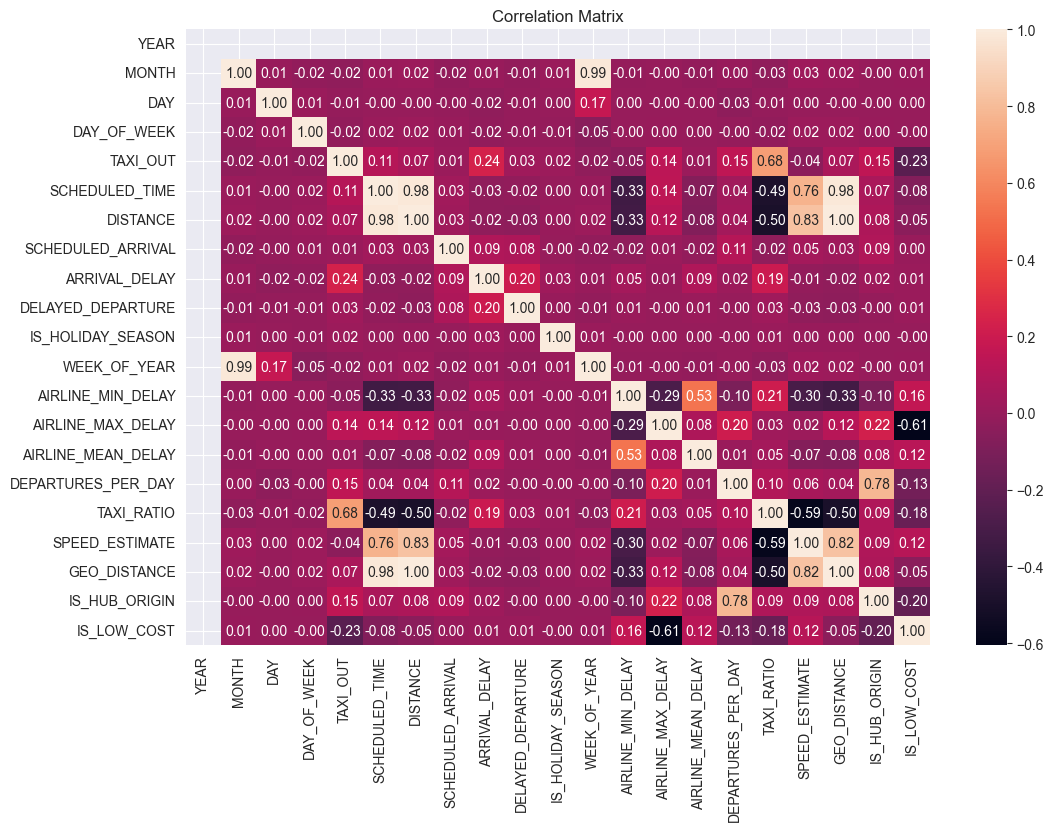

In [31]:
plt.figure(figsize=(12, 8))
corr = flights_train_cleaned.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show();

# Final Check and Data Store

In [32]:
# because we should not put nan values to the model we check if we have some
print(flights_train_cleaned.shape)
flights_train_cleaned.isnull().sum().sort_values(ascending=False)


(2816297, 28)


GEO_DISTANCE                4790
YEAR                           0
DAY                            0
MONTH                          0
AIRLINE                        0
ORIGIN_AIRPORT                 0
DESTINATION_AIRPORT            0
SCHEDULED_DEPARTURE_TIME       0
DEPARTURE_TIME                 0
TAXI_OUT                       0
WHEELS_OFF                     0
DAY_OF_WEEK                    0
SCHEDULED_TIME                 0
DISTANCE                       0
ARRIVAL_DELAY                  0
SCHEDULED_ARRIVAL              0
TIME_OF_DAY                    0
IS_HOLIDAY_SEASON              0
WEEK_OF_YEAR                   0
DELAYED_DEPARTURE              0
AIRLINE_MIN_DELAY              0
AIRLINE_MAX_DELAY              0
DEPARTURES_PER_DAY             0
AIRLINE_MEAN_DELAY             0
TAXI_RATIO                     0
SPEED_ESTIMATE                 0
IS_HUB_ORIGIN                  0
IS_LOW_COST                    0
dtype: int64

In [33]:
# the only nan values are with the geo distance therefore we change the mean values of the column
flights_train_cleaned['GEO_DISTANCE'] = flights_train_cleaned['GEO_DISTANCE'].fillna(flights_train_cleaned['GEO_DISTANCE'].median())
flights_test_cleaned['GEO_DISTANCE'] = flights_test_cleaned['GEO_DISTANCE'].fillna(flights_test_cleaned['GEO_DISTANCE'].median())

# store the prepared data for one hot encoding and modeling
flights_train_cleaned.to_csv('data/flights_train_cleaned.csv', index=False)
flights_test_cleaned.to_csv('data/flights_test_cleaned.csv', index=False)